# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [3]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 10 # 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 200 # 300
hidden_layer_dim = 32
batch_size = 16 # 64
nb_epochs = 100
dropout = 0.3
recurrent_dropout=  0.6
patience = 10
verbose = 0

useF1Score = False # True

## Create <caption,label> CSV files

In [4]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

## Divide data into train/val/test datasets

In [5]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()


inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

print("df.head()\n", df.head())
print("inputDataset.head()\n", inputDataset.head())
print("testDataset.head()\n", testDataset.head())
print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())

df.head()
   imageId                                            caption  label
0      I1           two acorns lying ground next oak leaves.      0
1      I2  three acorns flat surface. one acorn missing c...      0
2      I3  five acorns arranged circle black background. ...      0
3      I4  two cocktails brown wooden table. cocktail fro...      0
4      I5                three shelves full bottles whiskey.      0
inputDataset.head()
    index                                            caption  label
0    723                    two sea lions face open mouths.      0
1    751  empty lighted ski run twilight spectators watc...      0
2    309                        pile dog feces lying grass.     -1
3    104  group young students classroom knees hands fol...      0
4    446         close-up computer keyboard. layout german.      0
testDataset.head()
    index                                            caption  label
0    340  flooded river flowing bridge carrying vehicula...     -1
1   

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 1193514
embedding dimension : (200,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


config:
 {'kfold_splits': 10, 'batch_size': 16, 'embedding_dimension': 200, 'recurrent_dropout': 0.6, 'dropout': 0.3, 'nb_epochs': 100, 'useF1Score': False, 'verbose': 0}
# words:  1193514  word vector dimension 200
Label distribution:  label
-1    147
 0    378
 1    285
Name: label, dtype: int64
max_seq_len 38
class_weights [0.72654691 1.8245614  0.92975734]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    133
 0    334
 1    261
Name: label, dtype: int64
Val label distribution:  label
-1    14
 0    44
 1    24
Name: label, dtype: int64
Instructions for updating:
Use the retry module or similar alternatives.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



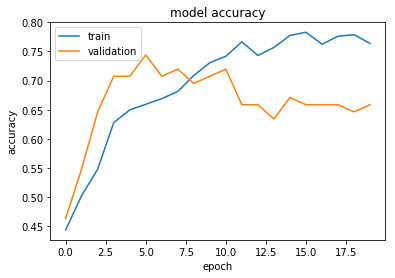

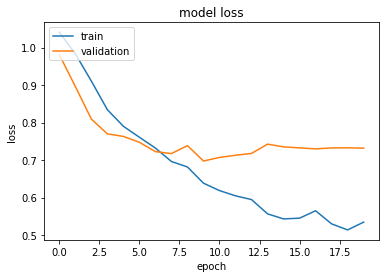

Time passed for training 105.49187231063843
class_weights [0.71583088 1.79753086 0.95538058]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    135
 0    339
 1    254
Name: label, dtype: int64
Val label distribution:  label
-1    12
 0    39
 1    31
Name: label, dtype: int64

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
best_val_acc:  0.6219512195121951
best_train_acc 0.760989010989011
best_val_acc 0.6219512195121951


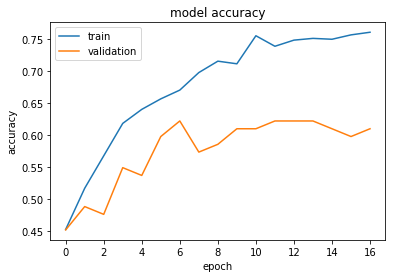

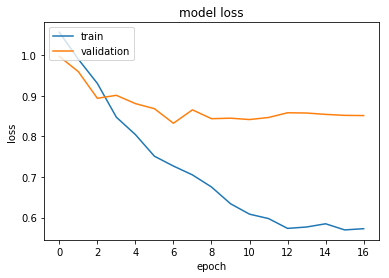

Time passed for training 87.39904975891113
class_weights [0.73092369 0.91919192 1.83838384]
class_to_index {0: 0, 1: 1, -1: 2}

TRAIN size: 728 	 VAL size: 82
Train label distribution:  label
-1    132
 0    332
 1    264
Name: label, dtype: int64
Val label distribution:  label
-1    15
 0    46
 1    21
Name: label, dtype: int64


In [ ]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))

#     model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, dropout=config['dropout'],
#                                 recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
#     model.add(Bidirectional(GRU(max_seq_len, dropout=config['dropout'] - 0.1, 
#                                 recurrent_dropout=config['recurrent_dropout'] - 0.1 ), merge_mode='concat'))    
    model.add(LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model




def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    y_pred = predictionClasses
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train_caption, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
        y_ints = [y.argmax() for y in y_train]
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
        print("class_weights", class_weights)
        print("class_to_index", class_to_index)
        
        dfVal= pd.concat([X_val_caption, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,num_of_classes, config)
        
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        
        # Log to tensorboard
        tensorBoardCallback = TensorBoard(log_dir=model_results_root_dir + '/logs', write_graph=True)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=2, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping, tensorBoardCallback]  # 
        
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list,
                      class_weight = class_weights)        # 
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()

In [ ]:

        
        

evalaute_on_test_data(best_model, testDataset, inputDataset,wordToVec, get_config())

## Determien Vocabulary size - unique word counts

In [ ]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    

# New Train on Twitter dataset, validate on OASIS images caption dataset

1,578,628 Tweets with positive/negative sentiments - labelled data

In [ ]:
# %matplotlib inline
# import os, sys
# import re
# import string
# import pathlib
# import random
# from collections import Counter, OrderedDict
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import spacy
# from tqdm import tqdm, tqdm_notebook, tnrange
# #tqdm.pandas(desc='Progress')

# from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
# from sklearn.metrics import accuracy_score

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'

# import warnings
# warnings.filterwarnings('ignore')



In [ ]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()


# twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Sentiment_Analysis_Dataset.csv" 
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv" 
# df = pd.read_csv(twitter_dataset_path, error_bad_lines=False)
# df = df[['SentimentText','Sentiment']]
# df["SentimentText"] = df["SentimentText"].apply(lambda x: tokenizer(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
# df.columns = ['caption','label']
# df = df.dropna()
# df.to_csv(cleaned_twitter_dataset_path, index=False)
# print("df.shape", df.shape)
# print("df.head()", df.head())

# fig = plt.figure(figsize=(8,5))
# ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
# ax.set(xlabel='Labels');

## Train on Twitter dataset, validate on Image captions

In [ ]:
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv"


# def build_model(max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
#     # Cross-validation results: 0.61% (+/- 0.13%)
#     model = Sequential()
#     model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
#     #, dropout=dropout, recurrent_dropout=recurrent_dropout
#     model.add(GRU(max_seq_len,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
#     #model.add(GRU(max_seq_len // 2,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
#     model.add(Dropout(0.2))
#     model.add(GRU(max_seq_len, dropout=dropout, recurrent_dropout=recurrent_dropout)) 
# #     model.add(Dropout(dropout))
    
    
#     model.add(Dense(num_of_classes, activation=final_activation))

#     model.compile(loss='categorical_crossentropy', optimizer='adam', 
#                       metrics=['accuracy', sc.f1, sc.recall, sc.precision])#
#     print(model.summary())
#     return model


# def convert_twitter_labels(x):
#     """twitter has 0 for negative, 1 for positive"""
#     if x == 0:
#         return -1
#     elif x == 1 :
#         return 1
#     else:
#         raise "Unexpectedvalue" + x

# def twitter_train_StratifiedKFold(config):
#     """StratifiedKFold cross-validation to solve class imbalance issue"""
    
#     dfTwitter = pd.read_csv(cleaned_twitter_dataset_path, header=0)
#     print(dfTwitter.head())
#     dfTwitter.columns = ['caption', 'label']
#     dfTwitter = dfTwitter.dropna()
#     dfTwitterPos = dfTwitter[dfTwitter.label == 1]
#     dfTwitterPos = dfTwitterPos[:5000]
#     dfTwitterNeg = dfTwitter[dfTwitter.label == 0]
#     dfTwitterNeg = dfTwitterNeg[:5000]
#     dfTwitter =  pd.concat([dfTwitterNeg, dfTwitterPos]) 

#     print("dfTwitter.count()",dfTwitter.count())
#     print("dfTwitter Label distribution: ",dfTwitter.groupby("label").label.count())
#     dfTwitter["label"] = dfTwitter["label"].apply(lambda x: convert_twitter_labels(x))
#     print("dfTwitter Label distribution: ",dfTwitter.groupby("label").label.count())
    
#     dfCaption = pd.read_csv(dataset_path, header=0, sep="|")   

#     print("Label distribution: ",dfCaption.groupby('label').label.count())
#     max_seq_len_captions = int(dfCaption['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
#     print("max_seq_len_captions", max_seq_len_captions)
    
#     max_seq_len_tweets = int(dfTwitter['caption'].map(lambda x: len(x.split())).max())
#     print("max_seq_len_tweets", max_seq_len_tweets)
    
#     max_seq_len = max(max_seq_len_captions,max_seq_len_tweets)
#     print("max_seq_len", max_seq_len)
    
    
    
#     X = dfCaption['caption']
#     y = dfCaption['label']

#     final_activation ='softmax'
#     print("final_activation",final_activation)
    
    
#     # Instantiate the cross validator
#     skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
#     printCnt = 5
#     cv_accuracies = []
#     cv_f1s = []
    
#     # Loop through the indices the split() method returns
#     for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        
#         X_train_caption, X_val_caption = X[train_indices], X[val_indices]
#         y_train_caption, y_val_caption = y[train_indices], y[val_indices]
        
#         dfCaptionTrain = pd.concat([X_train_caption, y_train_caption], axis=1) 
#         dfCaptionTrain["label"] = dfCaptionTrain["label"].apply(lambda x: caput.change_label_str_to_int(x))
#         dfTweetCaptionTrain = pd.concat([dfTwitter, dfCaptionTrain])               
        
#         #X_train, y_train_index, num_of_classes = caput.load_dataset_StratifiedKFold(dfTweetCaptionTrain, max_seq_len)
        
#         class_to_index = {}
#         index_to_class = {}
#         X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
#             caput.load_dataset_StratifiedKFold(
#                             dfTweetCaptionTrain,
#                             wordToVec, 
#                             max_seq_len, 
#                             class_to_index, 
#                             index_to_class,
#                             config)
        
#         y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes)
#         print("Train label distribution: ",dfTweetCaptionTrain.groupby('label').label.count())
#         print("num_of_classes",num_of_classes)
        
#         y_ints = [y.argmax() for y in y_train]
#         class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_ints),
#                                                  y_ints)
#         print("class_weights", class_weights)
#         print("class_to_index", class_to_index)
        
        
#         dfCaptionVal = pd.concat([X_val_caption, y_val_caption], axis=1) 
#         dfCaptionVal["label"] = dfCaptionVal["label"].apply(lambda x: caput.change_label_str_to_int(x))
#         #X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfCaptionVal,max_seq_len)
#         X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
#                             dfCaptionVal,
#                             wordToVec,
#                             max_seq_len, 
#                             class_to_index, 
#                             index_to_class,
#                             config)
        
        
        
#         y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
#         print("Val label distribution: ",dfCaptionVal.groupby('label').label.count())       

#         model = build_model(max_seq_len,
#                                 num_of_classes, 
#                                 embedding_dim=config['embedding_dimension'], 
#                                 hidden_layer_dim=config['hidden_layer_dim'], 
#                                 dropout=config['dropout'], 
#                                 recurrent_dropout=config['recurrent_dropout'],# 0.3
#                                 final_activation=final_activation                                
#                                 )
#         plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#

#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                   factor=0.5, 
#                                   patience=2, 
#                                   min_lr=1e-7,
#                                   cooldown=1,
#                                   verbose=1)

#         history = {}
#         filename = ""
#         # checkpoint
#         filepath="model/weights.best.h5"
#         checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
#         early_stopping = EarlyStopping(monitor='val_loss', patience=5)    
#         callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
#         history = model.fit(x=X_train,
#                           y=y_train, 
#                           batch_size=config['batch_size'],# 64 seems fine, 32 is better 
#                           epochs=config['nb_epochs'], 
#                           verbose=config['verbose'], 
#                           validation_data = (X_val, y_val),
#                           shuffle=True,
#                           callbacks=callbacks_list,
#                           class_weight = class_weights)        
        
#         val_acc_list = history.history['val_acc']
#         val_f1_list = history.history['val_f1']
#         best_val_acc =  max(val_acc_list)
#         best_f1 =  max(val_f1_list)
#         print("best_val_acc: ", best_val_acc)
#         print("best_f1: ", best_f1)
#         filename = "hec" 
#         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
#         os.rename(filepath, filename)
#         cv_accuracies.append(best_val_acc)
#         cv_f1s.append(best_f1)
#         plot_model_accuracy(history, "model/")
#         end = time.time()
#         print("Time passed for training", (end-start)/60)
    
#     print("=========================================")
#     print("Cross-validation val accuracy results: " , cv_accuracies)
#     print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
#     print("\n","Cross-validation val f1 results: " , cv_f1s)
#     print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
#     return history



# def get_config():
#     conf = {}
#     kfold_splits = 7
#     embedding_dimension = 200
#     conf["kfold_splits"] = kfold_splits
#     conf["batch_size"] = batch_size
#     conf['embedding_dimension'] = embedding_dimension
#     conf['recurrent_dropout'] = recurrent_dropout
#     conf['dropout'] = dropout
#     conf["nb_epochs"] = nb_epochs
#     conf['useF1Score'] = useF1Score
#     conf['verbose'] = 1
#     conf['useF1Score'] = useF1Score
#     conf['hidden_layer_dim'] = hidden_layer_dim
#     return conf   

# dataset_path = human_output_caption_to_label_csv_path
# # dataset_path = auto_output_caption_to_label_csv_path

# best_model = None
# def main():
#     global wordToVec, best_model
#     config = get_config()
#     print("config:\n", config)
#     if wordToVec is None:
#         wordToVec = load_embedding(fasttext_embedding_path)
#     print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
#     best_model = history = twitter_train_StratifiedKFold(config) 
#     # Evaluate Test data set
#     #evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
#     pass

# if __name__ == "__main__":
#     # execute only if run as a script
#     main()



